## Dependencies

In [1]:
import numpy as np
import pandas as pd

import requests
from io import BytesIO 
from zipfile import ZipFile

import math
from numpy.random import normal
import datetime
from sklearn.preprocessing import StandardScaler

import torch
from torch_kalman.kalman_filter import KalmanFilter
from torch_kalman.process import LocalLevel, LocalTrend, Season, FourierSeasonDynamic, FourierSeasonFixed, NN
from torch_kalman.utils.data import TimeSeriesDataset, TimeSeriesDataLoader

from plotnine import *
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose, STL

## UCI Machine Learning Data Repository - Beijing Multi-Site Air-Quality Data Set

This data set includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites. The air-quality data are from the Beijing Municipal Environmental Monitoring Center. The meteorological data in each air-quality site are matched with the nearest weather station from the China Meteorological Administration. The time period is from March 1st, 2013 to February 28th, 2017. 

For this example we will focus on 1 site (Tiantan). We will predict the amount of carbon monoxide pollutant present in the air (ug/m^3) at the end of each work day (5p.m. local time)

In [2]:
# Read in data
response = requests.get('http://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip')
zip_file = ZipFile(BytesIO(response.content))
files = zip_file.namelist()

In [3]:
df = pd.read_csv(zip_file.open(files[10]))

# For now we're only interested in CO levels right at the end of the work day:
df = df[df.hour == 17]

#### Understanding the data

In [4]:
df.dtypes

No           int64
year         int64
month        int64
day          int64
hour         int64
PM2.5      float64
PM10       float64
SO2        float64
NO2        float64
CO         float64
O3         float64
TEMP       float64
PRES       float64
DEWP       float64
RAIN       float64
wd          object
WSPM       float64
station     object
dtype: object

In [5]:
df.describe()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,1461.000000,1461.00000,1461.000000,1461.000000,1461.0,1427.000000,1434.000000,1413.000000,1430.000000,1418.000000,1429.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,17538.000000,2014.66256,6.522930,15.729637,17.0,76.837421,105.916318,16.772824,42.820604,1083.415374,104.002167,16.906906,1010.969952,1.644422,0.054552,2.323546
std,10125.568428,1.17760,3.449884,8.803105,0.0,80.409812,87.240041,22.757343,34.411700,1073.753860,76.886490,11.449075,10.254098,13.938497,0.540156,1.381738
min,18.000000,2013.00000,1.000000,1.000000,17.0,3.000000,3.000000,1.000000,2.000000,100.000000,1.000000,-15.300000,987.500000,-33.800000,0.000000,0.000000
25%,8778.000000,2014.00000,4.000000,8.000000,17.0,19.000000,43.250000,3.000000,19.250000,400.000000,45.000000,6.100000,1002.400000,-10.000000,0.000000,1.300000
50%,17538.000000,2015.00000,7.000000,16.000000,17.0,51.000000,81.000000,8.000000,30.000000,700.000000,88.000000,18.200000,1010.400000,2.000000,0.000000,2.000000
75%,26298.000000,2016.00000,10.000000,23.000000,17.0,103.500000,140.000000,20.000000,54.000000,1300.000000,159.000000,27.200000,1019.300000,14.000000,0.000000,3.000000
max,35058.000000,2017.00000,12.000000,31.000000,17.0,650.000000,650.000000,202.000000,224.000000,9300.000000,673.000000,38.200000,1039.700000,28.500000,13.400000,9.700000


In [6]:
df.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
PM2.5      34
PM10       27
SO2        48
NO2        31
CO         43
O3         32
TEMP        0
PRES        0
DEWP        0
RAIN        0
wd          0
WSPM        0
station     0
dtype: int64

In [7]:
np.unique(df['station'], return_counts=True)

(array(['Tiantan'], dtype=object), array([1461]))

In [8]:
np.unique(df['wd'].astype(str), return_counts=True)

(array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW'], dtype=object),
 array([104,  74, 108,  50,  68,  33,  57, 108, 115,  75,  92, 153, 201,
         36,  65, 122]))

#### Data transformations

In [9]:
# Create time index
df['time'] = pd.to_datetime(df[['year','month','day']])
#df['time'] = pd.to_datetime(df[['year','month','day','hour']])

# Dummy code Wind Direction (wd)
df = pd.concat([df, pd.get_dummies(df['wd'])], axis=1)
df.drop(['wd'], inplace=True, axis=1)

# Linearly interpolate any missing values in CO and predictors:
for col in ['CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']:
    df[col] = df[col].interpolate(method='linear')

# Training data: pre- March 2016
# Testing data: March 2016 - March 2017
train_test_cutoff_date = datetime.date(2016,3,1)
train_df = df[df['time'] < train_test_cutoff_date]
test_df = df[df['time'] >= train_test_cutoff_date]

# Standardize data: Fit and transform training data
train_scaler = StandardScaler()
train_df[['CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM',
       'E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
       'SSW', 'SW', 'W', 'WNW', 'WSW', 'E', 'ENE', 'ESE', 'N', 'NE', 'NNE',
       'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW']] = train_scaler. \
fit_transform(train_df[['CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM',
       'E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
       'SSW', 'SW', 'W', 'WNW', 'WSW', 'E', 'ENE', 'ESE', 'N', 'NE', 'NNE',
       'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW']].to_numpy())

# Standardize data: Transform testing data using train_scaler
test_df[['CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM',
       'E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
       'SSW', 'SW', 'W', 'WNW', 'WSW', 'E', 'ENE', 'ESE', 'N', 'NE', 'NNE',
       'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW']] = train_scaler. \
transform(test_df[['CO', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM',
       'E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
       'SSW', 'SW', 'W', 'WNW', 'WSW', 'E', 'ENE', 'ESE', 'N', 'NE', 'NNE',
       'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW']].to_numpy())

/Users/noahsalas/anaconda3/envs/kf/lib/python3.6/site-packages/ipykernel/__main__.py:16: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
/Users/noahsalas/anaconda3/envs/kf/lib/python3.6/site-packages/ipykernel/__main__.py:17: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
/Users/noahsalas/anaconda3/envs/kf/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

It appears our target variable has an annual seasonality:

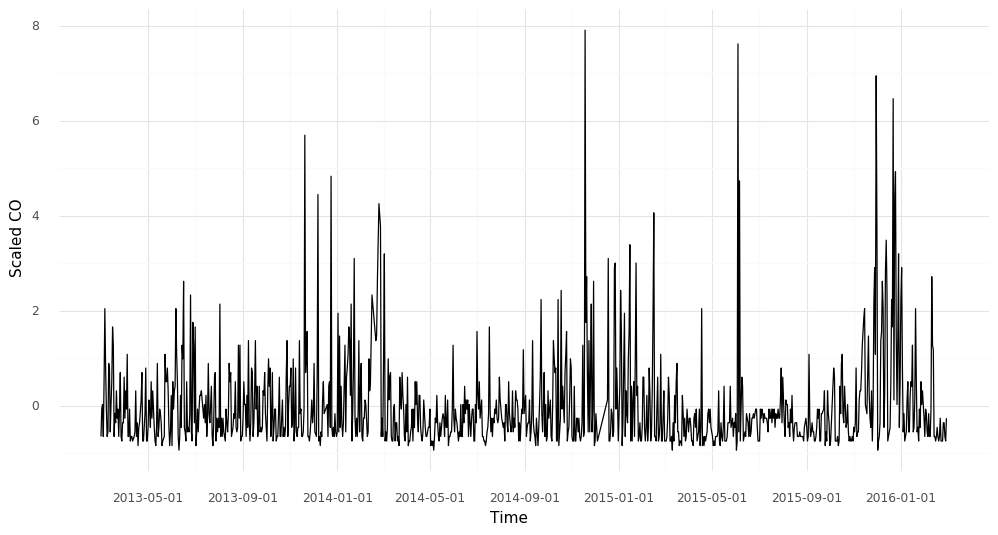

<ggplot: (-9223372036562395525)>


In [10]:
print(
    ggplot(train_df, aes(x='time', y='CO')) + \
                geom_line() + \
                ylab("Scaled CO") + xlab("Time") + \
                theme_minimal() + theme(figure_size=(12, 6))
)

`CO` Variance appears to be seasonal as well:

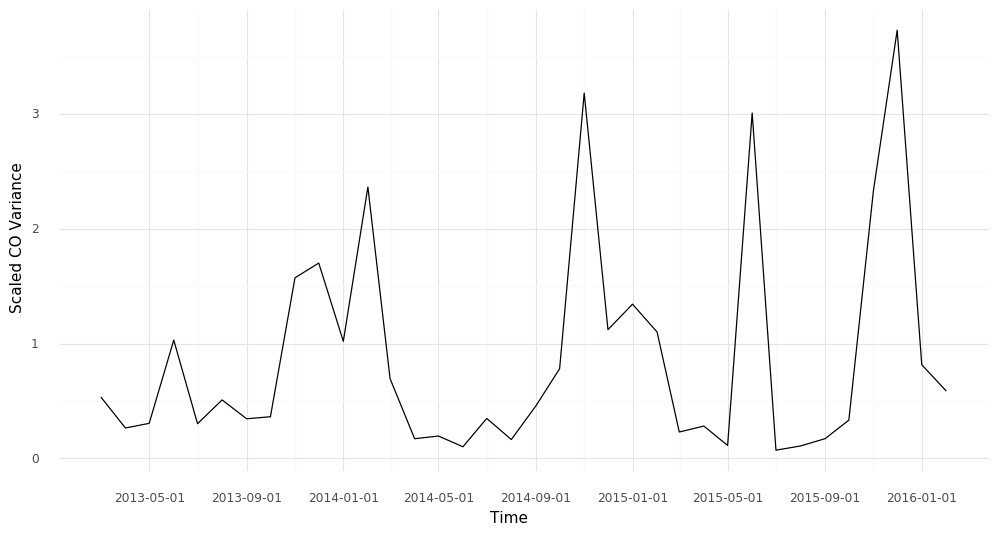

<ggplot: (278055481)>


In [11]:
var_df = train_df.groupby(['year','month'])['CO'].var().reset_index().assign(day=1)
var_df['time'] = pd.to_datetime(var_df[['year','month','day']])
print(
    ggplot(var_df, aes(x='time', y='CO')) + \
                geom_line() + \
                ylab("Scaled CO Variance") + xlab("Time") + \
                theme_minimal() + theme(figure_size=(12, 6))
)

The meteorological data (potential predictors) also appear to have an annual seasonality:

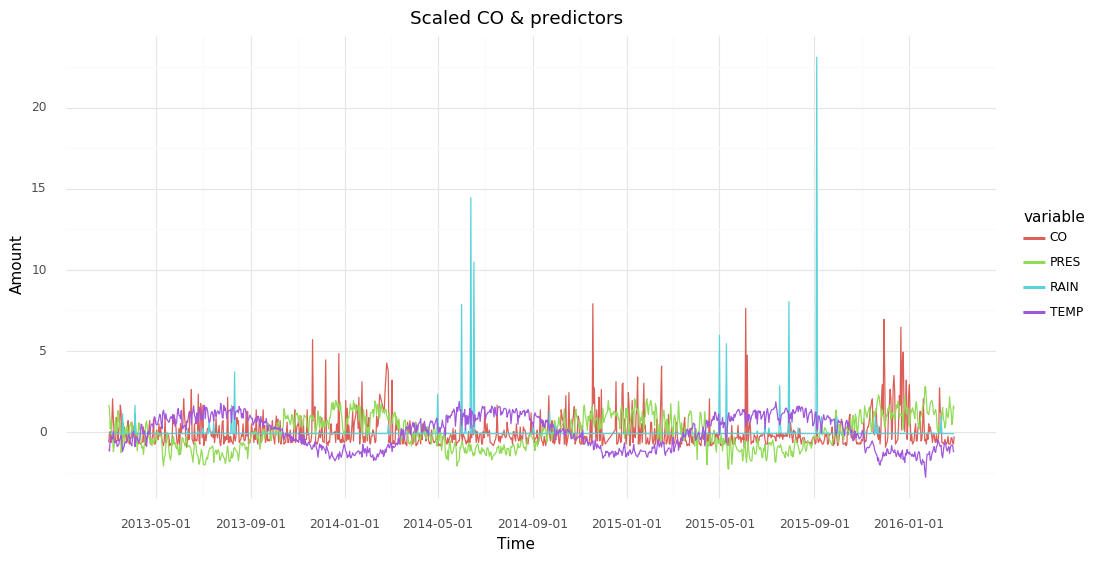

<ggplot: (-9223372036561546492)>


In [12]:
tempdf = train_df[['time','CO','TEMP','PRES','RAIN']].melt(id_vars=['time'])

print(
    ggplot(tempdf, aes(x='time', y='value', color='variable')) + \
                geom_line() + \
                ylab("Amount") + xlab("Time") + \
                theme_minimal() + ggtitle('Scaled CO & predictors') + theme(figure_size=(12, 6))
)

#### Time series decomposition

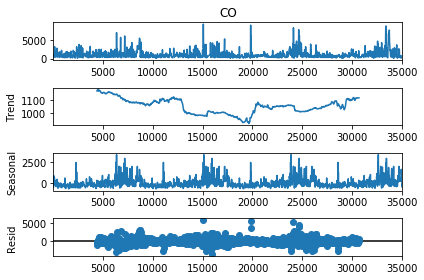

In [13]:
result = seasonal_decompose(df['CO'], model="additive", period=365)
result.plot()
pyplot.show()

## Train on target series only

Let's build our Kalman filter. First let's define some global variables that will help us deinfe when seasonalities start and at what time granularity the data is at:

In [14]:
season_config = {
    'season_start': pd.Timestamp('2014-01-01'),  # Seasonality start date 
    'dt_unit': 'D'  # data is at daily level
}

In roder to create our Kalman Filter, we need *measures* and *processes*. Measures are simply our outcome(s) of interest. Processes are models we use to understand our system- i.e. what makes us go from one state to another. In time series applications, we often already have an intuitive understanding of such processes. There could be a trend, different seasonalities, exogneous factors, etc. `torch-kalman` allows you to specify these in an easy and clear way. For instance we can define a `LocalLevel` (random walk) process as well as `FourierSeasonFixed` a seasonality process using a fourier series:

In [15]:
kf = KalmanFilter(
    measures=['CO'],
    processes=[
        LocalLevel(id='local_level').add_measure('CO'),
        FourierSeasonFixed(id='day_in_year', seasonal_period=365, K=2, **season_config).add_measure('CO')
    ]
)

Once this is in place, we can leverage `torch` to optimize our parameters of interest:

- Measurement Noise
- Process Noise


In [16]:
kf.opt = torch.optim.Adam(kf.parameters(), lr=0.1)

And before training, we'll use `TimeSeriesDataset`s (which mimic `TensorDatasets`) to shape our data in a way that can be used by `torch-kalman`. This shape is `(group, time, measure)` but for now we only have 1 group (`station`) and 1 measure (`CO`):

In [17]:
train_batch = TimeSeriesDataset.from_dataframe(dataframe=train_df, 
                                               group_colname = 'station',
                                               time_colname = 'time',
                                               measure_colnames = ['CO'],
                                               dt_unit=season_config['dt_unit'])

test_batch = TimeSeriesDataset.from_dataframe(dataframe=test_df, 
                                               group_colname = 'station',
                                               time_colname = 'time',
                                               measure_colnames = ['CO'],
                                               dt_unit=season_config['dt_unit'])

And finally we train our model:

EPOCH 0, TRAIN LOSS 1.6120765209197998, VALIDATION LOSS 1.4991869926452637
EPOCH 1, TRAIN LOSS 1.530547857284546, VALIDATION LOSS 1.4330092668533325
EPOCH 2, TRAIN LOSS 1.4702919721603394, VALIDATION LOSS 1.3921602964401245
EPOCH 3, TRAIN LOSS 1.4349687099456787, VALIDATION LOSS 1.378024697303772
EPOCH 4, TRAIN LOSS 1.425826072692871, VALIDATION LOSS 1.3852159976959229
EPOCH 5, TRAIN LOSS 1.4366751909255981, VALIDATION LOSS 1.3996291160583496
EPOCH 6, TRAIN LOSS 1.4518136978149414, VALIDATION LOSS 1.4075422286987305
EPOCH 7, TRAIN LOSS 1.4574511051177979, VALIDATION LOSS 1.4054259061813354
EPOCH 8, TRAIN LOSS 1.451368808746338, VALIDATION LOSS 1.397075891494751
EPOCH 9, TRAIN LOSS 1.4383277893066406, VALIDATION LOSS 1.3876011371612549
EPOCH 10, TRAIN LOSS 1.423965573310852, VALIDATION LOSS 1.3804866075515747
EPOCH 11, TRAIN LOSS 1.4122599363327026, VALIDATION LOSS 1.3772987127304077
EPOCH 12, TRAIN LOSS 1.4050382375717163, VALIDATION LOSS 1.3780033588409424
EPOCH 13, TRAIN LOSS 1.40227

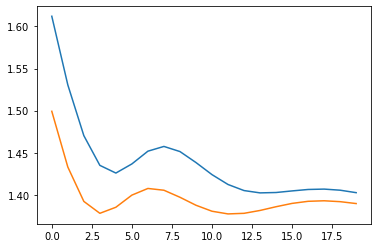

In [18]:
def closure():
    kf.opt.zero_grad()
    y = train_batch.tensors[0]
    pred = kf(y, 
              start_datetimes=train_batch.start_datetimes)
    loss = -pred.log_prob(y).mean()
    loss.backward()
    return loss

def valid():
    with torch.no_grad():
        y = test_batch.tensors[0]
        pred = kf(y, 
                  start_datetimes=test_batch.start_datetimes)
        loss = -pred.log_prob(y).mean()
        return loss

train_losses = []
valid_losses = []
NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    train_loss = kf.opt.step(closure)
    valid_loss = valid()
    train_losses.append(train_loss.item())
    valid_losses.append(valid_loss.item())
    print(f"EPOCH {epoch}, TRAIN LOSS {train_loss.item()}, VALIDATION LOSS {valid_loss.item()}")
    
pyplot.plot(train_losses)
pyplot.plot(valid_losses)
pyplot.show()

Let's view our performance. We'll pass our training data, and forecast out the length of our validation data. We then merge our predictions with all data and plot.

In [19]:
# get validation forecasts
with torch.no_grad():

    trainy = train_batch.tensors[0]

    preds = kf(trainy, 
              start_datetimes = train_batch.start_datetimes,
              forecast_horizon = test_df.shape[0])

# join validation predictions with all data
all_df = pd.concat([train_df,test_df])
all_batch = TimeSeriesDataset.from_dataframe(dataframe=all_df, 
                                               group_colname = 'station',
                                               time_colname = 'time',
                                               measure_colnames = ['CO'],
                                               dt_unit=season_config['dt_unit'])


pred_df = preds.to_dataframe(all_batch) \
.merge(all_df[['time','CO']], how='right', left_on='date_time', right_on='time') \
.assign(predicted_min = lambda x: x['predicted_mean'] - x['predicted_std'],
        predicted_max = lambda x: x['predicted_mean'] + x['predicted_std'])

Our average predictions appear to follow the yearly trend, and our uncertainty increase the farther out we make forecasts:

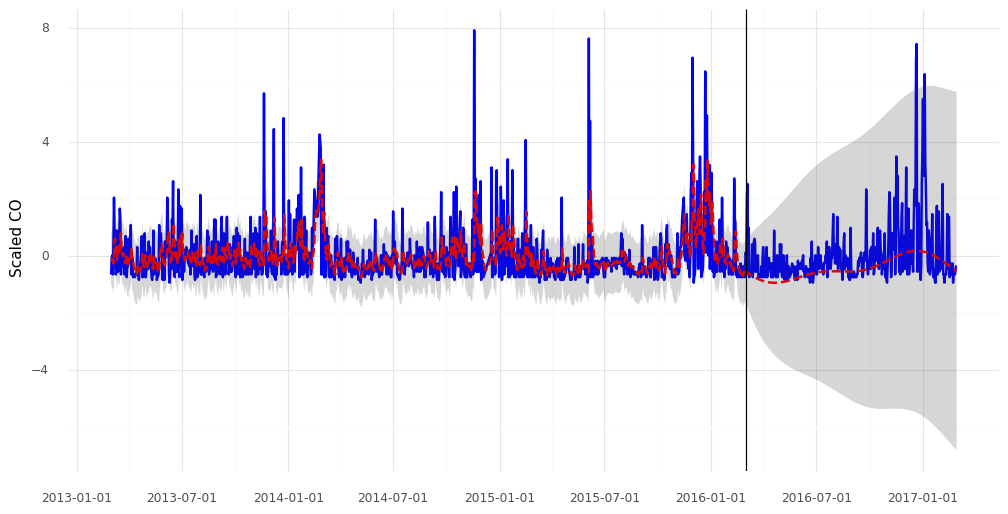

<ggplot: (-9223372036561546282)>


In [20]:
# plot
print(
    ggplot(pred_df,
           aes(x='date_time')) +
    geom_line(aes(y='CO'), color='blue', size=1) +
    geom_line(aes(y='predicted_mean'), color='red', size=1, linetype = 'dashed') +
    geom_ribbon(aes(ymin='predicted_min', ymax='predicted_max'), alpha=.20) +
    theme_minimal() +
    theme(figure_size=(12, 6)) +
    geom_vline(xintercept=train_test_cutoff_date) +
    scale_x_date(name="") + scale_y_continuous(name="Scaled CO")
)

Accuracy statistics:

In [21]:
test_pred_df = pred_df[pred_df['date_time'] >= pd.Timestamp(train_test_cutoff_date)]
rmse = np.sqrt(((test_pred_df['CO'] - test_pred_df['predicted_mean']) ** 2).mean())
mae = np.mean(np.abs((test_pred_df['CO'] - test_pred_df['predicted_mean'])))
print(f"VALIDATION RMSE {rmse}, VALIDATION MAE {mae}")

VALIDATION RMSE 1.1110985846351853, VALIDATION MAE 0.6702404638283206


## Train with exogenous predictors that are embedded in a single state value using NN

Our predictions look ok, but can we leverage additional features like the meteorlogical data to improve accuracy?

In [22]:
predictors = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

Since we're using `torch` why not leverage some sort of architecture to take predictors in as inputs, and output some latent representation of the process state?

In [23]:
input_dim = len(predictors)
output_dim = 1
state_emb_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 50, bias=False),
    torch.nn.Tanh(),
    torch.nn.Linear(50, output_dim, bias=False)
)

We can specify these exogenous predictors as simply another process:

In [24]:
kf_exo = KalmanFilter(
    measures=['CO'],
    processes=[
        LocalLevel(id='local_level').add_measure('CO'),
        FourierSeasonFixed(id='day_in_year', seasonal_period=365, K=2, **season_config).add_measure('CO'),
        NN(id='predictors',
           input_dim=input_dim,
           state_dim=output_dim,
           nn_module=state_emb_model,
           add_module_params_to_process=False).add_measure('CO')
    ]
)

And now we train the same as before:

EPOCH 0, TRAIN LOSS 1.597307562828064, VALIDATION LOSS 1.4675246477127075
EPOCH 1, TRAIN LOSS 1.4871466159820557, VALIDATION LOSS 1.365415334701538
EPOCH 2, TRAIN LOSS 1.397663950920105, VALIDATION LOSS 1.283400058746338
EPOCH 3, TRAIN LOSS 1.3310267925262451, VALIDATION LOSS 1.2208539247512817
EPOCH 4, TRAIN LOSS 1.2842918634414673, VALIDATION LOSS 1.1802312135696411
EPOCH 5, TRAIN LOSS 1.2580647468566895, VALIDATION LOSS 1.165515661239624
EPOCH 6, TRAIN LOSS 1.253621220588684, VALIDATION LOSS 1.1735758781433105
EPOCH 7, TRAIN LOSS 1.266764760017395, VALIDATION LOSS 1.1859344244003296
EPOCH 8, TRAIN LOSS 1.278709053993225, VALIDATION LOSS 1.1880041360855103
EPOCH 9, TRAIN LOSS 1.2754549980163574, VALIDATION LOSS 1.1823153495788574
EPOCH 10, TRAIN LOSS 1.2624034881591797, VALIDATION LOSS 1.1751679182052612
EPOCH 11, TRAIN LOSS 1.247598648071289, VALIDATION LOSS 1.1698681116104126
EPOCH 12, TRAIN LOSS 1.2345914840698242, VALIDATION LOSS 1.1673400402069092
EPOCH 13, TRAIN LOSS 1.22454750

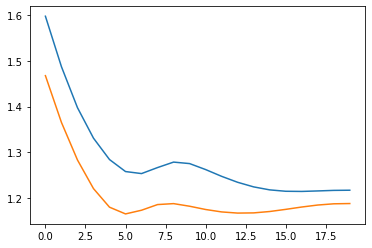

In [25]:
kf_exo.opt = torch.optim.Adam([{'params': kf_exo.parameters(), 'lr': 0.1},
                                  {'params': state_emb_model.parameters(), 'lr': 0.01}])

train_batch = TimeSeriesDataset.from_dataframe(dataframe=train_df, 
                                               group_colname = 'station',
                                               time_colname = 'time',
                                               measure_colnames = ['CO'] + predictors,
                                               dt_unit=season_config['dt_unit'])
train_batch = train_batch.split_measures(['CO'], predictors)

test_batch = TimeSeriesDataset.from_dataframe(dataframe=test_df, 
                                               group_colname = 'station',
                                               time_colname = 'time',
                                               measure_colnames = ['CO'] + predictors,
                                               dt_unit=season_config['dt_unit'])

test_batch = test_batch.split_measures(['CO'], predictors)


def closure():
    kf_exo.opt.zero_grad()
    y, X = train_batch.tensors
    pred = kf_exo(y, 
                  start_datetimes = train_batch.start_datetimes,
                  predictors = X)
    loss = -pred.log_prob(y).mean()
    loss.backward()
    return loss

def valid():
    with torch.no_grad():
        y, X = test_batch.tensors
        pred = kf_exo(y, 
                      start_datetimes=test_batch.start_datetimes,
                      predictors = X)
        loss = -pred.log_prob(y).mean()
        return loss

train_losses = []
valid_losses = []
NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    train_loss = kf_exo.opt.step(closure)
    valid_loss = valid()
    train_losses.append(train_loss.item())
    valid_losses.append(valid_loss.item())
    print(f"EPOCH {epoch}, TRAIN LOSS {train_loss.item()}, VALIDATION LOSS {valid_loss.item()}")
    
pyplot.plot(train_losses)
pyplot.plot(valid_losses)
pyplot.show()

It looks like our accuracy improved:

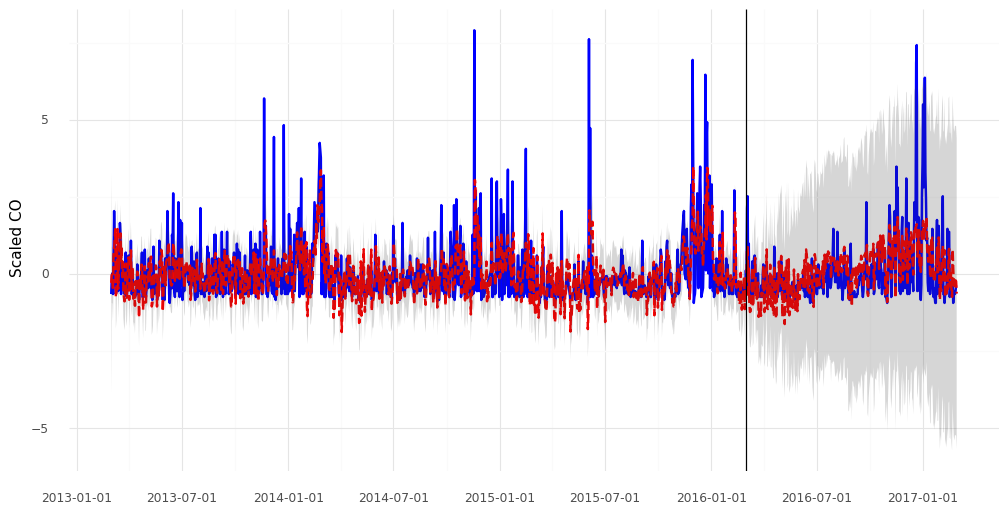

<ggplot: (-9223372036530533411)>


In [26]:
all_df = pd.concat([train_df,test_df])
all_batch = TimeSeriesDataset.from_dataframe(dataframe=all_df, 
                                               group_colname = 'station',
                                               time_colname = 'time',
                                               measure_colnames = ['CO'] + predictors,
                                               dt_unit=season_config['dt_unit'])
all_batch = all_batch.split_measures(['CO'], predictors)

with torch.no_grad():
    trainy, trainX = train_batch.tensors
    ally, allX = all_batch.tensors
    preds = kf_exo(trainy, 
                   start_datetimes = train_batch.start_datetimes,
                   predictors = allX,
                   forecast_horizon = test_df.shape[0])

pred_df = preds.to_dataframe(all_batch) \
.merge(all_df[['time','CO']], how='right', left_on='date_time', right_on='time') \
.assign(predicted_min = lambda x: x['predicted_mean'] - x['predicted_std'],
        predicted_max = lambda x: x['predicted_mean'] + x['predicted_std'])
print(
    ggplot(pred_df,
           aes(x='date_time')) +
    geom_line(aes(y='CO'), color='blue', size=1) +
    geom_line(aes(y='predicted_mean'), color='red', size=1, linetype = 'dashed') +
    geom_ribbon(aes(ymin='predicted_min', ymax='predicted_max'), alpha=.20) +
    theme_minimal() +
    theme(figure_size=(12, 6)) +
    geom_vline(xintercept=train_test_cutoff_date) +
    scale_x_date(name="") + scale_y_continuous(name="Scaled CO")
)

It did!

In [27]:
test_pred_df = pred_df[pred_df['date_time'] >= pd.Timestamp(train_test_cutoff_date)]
rmse = np.sqrt(((test_pred_df['CO'] - test_pred_df['predicted_mean']) ** 2).mean())
mae = np.mean(np.abs((test_pred_df['CO'] - test_pred_df['predicted_mean'])))
print(f"VALIDATION RMSE {rmse}, VALIDATION MAE {mae}")

VALIDATION RMSE 0.8303844278522593, VALIDATION MAE 0.5610127934452384


#### possible improvements

- train in cross validated way
- use more predictors / create fourier terms of predictors

#### next example ideas:

- multiple groups / measures
- analyze uncertainty further, plot many forecasted series based on sampling gaussin at each point